In [3]:
import os
from functools import partial
from itertools import product

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.ml_models import OutlierDataset

%reload_ext autoreload
%autoreload 2

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from NEExT.experiment_utils.data_loading import initialize_graph, semi_supervised_set
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.experiment_utils.models import score_unlabeled_gt
from NEExT.ml_models import CosineOutlierDetector


def objective(trial: optuna.Trial, model: str):
    structural_embedding_dimension = trial.suggest_int("structural_embedding_dimension", 1, 20)
    strategy = "structural_embedding"
    feature_embedding_dimension = 1

    embeddings = build_embeddings(
        subgraph_collection,
        structural_features,
        features,
        strategy=strategy,
        structural_embedding_dimension=structural_embedding_dimension,
        feature_embedding_dimension=feature_embedding_dimension,
    )
    dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)
    if model == "cosine":
        top_k = trial.suggest_int("top_k", 1, 20)
        detector = CosineOutlierDetector(top_k=top_k)
    elif model == "knn":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
        detector = KNeighborsClassifier(n_neighbors=n_neighbors)

    metric = cross_val_score(
        detector,
        dataset.X_labeled,
        dataset.y_labeled,
        cv=StratifiedKFold(5),
        n_jobs=-1,
        scoring=make_scorer(roc_auc_score),
    )
    return metric.mean()

In [26]:
graph_io = GraphIO()
path = "../local/data/simulated"
name = "abcdo_data_1000_200_0.1"
results = []


graph_data = {
    "name": name,
    "edge_file_path": f"{path}/{name}/edges.csv",
    "node_graph_mapping_file_path": f"{path}/{name}/graph_mapping.csv",
    "features_file_path": f"{path}/{name}/features.csv",
    "skip_features": ["community_id", "random_community_feature"],
    "feature_list": [],
    "target": "is_outlier",
}
model = 'cosine'
for f in [0.95, 0.9, 0.75, .5, .25, 0]:
    # TODO, SHOW AVERAGE + STDS ACROSS FRACTION OF LABELED KNOWN GOOD OBSERVATIONS
    frac = (1, f)

    edges_df, mapping_df, features_df, ground_truth_df = initialize_graph(graph_data, frac)
    # print(features_df['is_outlier'].value_counts())
    graph_collection = graph_io.load_from_dfs(
        edges_df=edges_df,
        node_graph_df=mapping_df,
        node_features_df=features_df,
        graph_type="igraph",
    )
    subgraph_collection = EgonetCollection()
    subgraph_collection.create_egonets_from_graphs(
        graph_collection=graph_collection,
        egonet_target=graph_data["target"],
        egonet_algorithm="k_hop_egonet",
        skip_features=graph_data["skip_features"],
        max_hop_length=1,
    )
    structural_features, features = build_features(subgraph_collection, feature_vector_length=6, feature_list=graph_data["feature_list"])
    
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective, model=model), n_trials=20, n_jobs=4)

    structural_embedding_dimension = study.best_params['structural_embedding_dimension']
    strategy = "structural_embedding"
    feature_embedding_dimension = 1
        
    embeddings = build_embeddings(
        subgraph_collection,
        structural_features,
        features,
        strategy=strategy,
        structural_embedding_dimension=structural_embedding_dimension,
        feature_embedding_dimension=feature_embedding_dimension,
    )
    dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)
    if model == "cosine":
        new_var = study.best_params['top_k']
        detector = CosineOutlierDetector(top_k=new_var)
    elif model == "knn":
        n_neighbors = study.best_params['n_neighbors']
        detector = KNeighborsClassifier(n_neighbors=n_neighbors)

    detector.fit(dataset.X_labeled, dataset.y_labeled)
    out_df, score = score_unlabeled_gt(dataset, detector, ground_truth_df)
    results.append({
        'model': model,
        'score': score,
        'frac_0': frac[0],
        'frac_1': frac[1],
    })

[I 2025-03-23 19:22:28,559] A new study created in memory with name: no-name-41a9120a-bfa2-4ca5-b26a-886588b69f5c
[I 2025-03-23 19:22:29,924] Trial 0 finished with value: 0.5 and parameters: {'structural_embedding_dimension': 1, 'top_k': 19}. Best is trial 0 with value: 0.5.
[I 2025-03-23 19:22:29,996] Trial 2 finished with value: 0.5 and parameters: {'structural_embedding_dimension': 6, 'top_k': 11}. Best is trial 0 with value: 0.5.
[I 2025-03-23 19:22:30,021] Trial 3 finished with value: 0.5431250000000001 and parameters: {'structural_embedding_dimension': 9, 'top_k': 1}. Best is trial 3 with value: 0.5431250000000001.
[I 2025-03-23 19:22:30,210] Trial 1 finished with value: 0.49812500000000004 and parameters: {'structural_embedding_dimension': 11, 'top_k': 4}. Best is trial 3 with value: 0.5431250000000001.
[I 2025-03-23 19:22:31,130] Trial 4 finished with value: 0.5 and parameters: {'structural_embedding_dimension': 12, 'top_k': 19}. Best is trial 3 with value: 0.5431250000000001.


In [27]:
r = pd.DataFrame(results)

In [28]:
r

,model,score,frac_0,frac_1
0,cosine,0.544375,1,0.95
1,cosine,0.593750,1,0.90
2,cosine,0.651250,1,0.75
3,cosine,0.653750,1,0.50
4,cosine,0.776875,1,0.25
5,cosine,0.782500,1,0.00


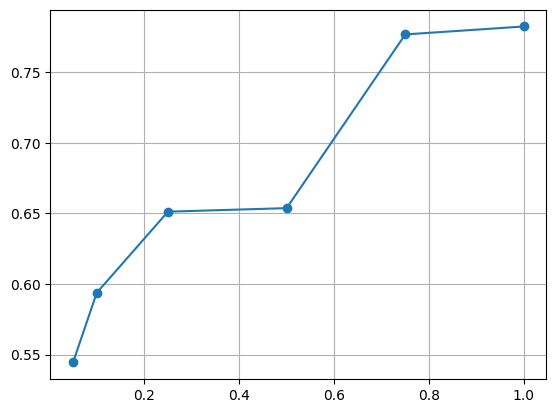

In [30]:
plt.plot(1-r['frac_1'], r['score'], '-o')
plt.grid(True)